# imports & settings

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%precision %.3f

from glob import glob
from tqdm import tqdm

from os.path import join
import ntpath 
from copy import deepcopy
import pytz
TZ = pytz.FixedOffset(540) # GMT+09:00; Asia/Seoulsilent


%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../') # to import from parent directory
import utils
from utils import *
import recept_dataset
from f_preprocessing import impute_support_features, impute, normalize

from sklearn import metrics 
from sklearn.model_selection import StratifiedKFold, GroupKFold

import warnings
from functools import reduce
from itertools import product

import matplotlib
matplotlib.rc('font', size=22)
from matplotlib import pyplot as plt

In [3]:
RANDOM_STATE=utils.RANDOM_STATE
DATAROOT = utils.DATAROOT
BALANCED_TRAINING = False
ALREADY_EXTRACTED_SUBFEATURES = True

## Function definitions for classification experiment

### metrics

In [4]:
def perf_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    y_pred_cls = np.rint(y_pred)    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        acc = metrics.accuracy_score(y_true, y_pred_cls)
        acc_bal = metrics.balanced_accuracy_score(y_true, y_pred_cls)
        f1_score = metrics.f1_score(
            y_true=y_true, y_pred=y_pred_cls,average='macro',pos_label=1
        )
        auc = metrics.roc_auc_score(
            y_true=y_true, y_score=y_pred, average='macro'
        )
    return dict(
        ACC=acc*100, ACC_BAL=acc_bal*100, F1_score = f1_score*100
        , AUC=auc
    )


### classifiers

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import catboost

classifiers = {
    'lr':LogisticRegression(random_state = RANDOM_STATE, max_iter=500 )
    ,'knn':KNeighborsClassifier(),
    'svm':SVC(probability=True),
    'gp':GaussianProcessClassifier(),
    'dt':DecisionTreeClassifier(random_state = RANDOM_STATE),
    'rf':RandomForestClassifier(random_state = RANDOM_STATE),
    'mlp':MLPClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gnb':GaussianNB(),
    'qda':QuadraticDiscriminantAnalysis(),
    'catboost': catboost.CatBoostClassifier(
        random_seed=RANDOM_STATE, eval_metric='AUC'
    )    
    #,'xgboost':xgb.Booster()
    }



classifier_names = {
    'lr':'LogisticRegression'
    ,'knn':'KNeighborsClassifier',
    'svm':'SVM',
    'gp':'GaussianProcess',
    'dt':'DecisionTree',
    'rf':'RandomForest',
    'mlp':'Multi-layer Perceptron',
    'adaboost':'AdaBoost',
    'gnb':'Gaussian Naive Bayes',
    'qda':'QuadraticDiscriminantAnalysis',
    'catboost':'CatBoost'
    #,'xgboost':'XGBoost'
}

### run_classification

In [6]:
def run_classification(
    df, use_ray = True,  cat_features=None, classifier_name='catboost',
    feature_selection = None, experiment_name=''
) :   
    y = df['receptivity'].replace({
        'receptive':1,'non-receptive':0
    })
    X = df.drop(columns='receptivity')
    pids = df.index.get_level_values('pid')

    results = LOGO_5fold(
        X,y, pids, feature_selection=feature_selection,
        cat_features=cat_features,
        classifier_name=classifier_name
        ,use_ray=use_ray
    )
    
    results.insert(results.shape[1], 'experiment',experiment_name)
    return results
    


### CV

In [7]:
def LOGO_5fold(
    X,y, pids, cat_features=None, classifier_name='catboost',
    feature_selection = None
    , use_ray=False
):
    func = ray.remote(run_trial).remote if use_ray else run_trial
    results = []    
    for train_index, test_index in tqdm(
        GroupKFold(n_splits=5).split(X, y, groups=pids)
    ):        
        res = func(
            X,y, train_index,test_index,
            cat_features=cat_features, classifier_name=classifier_name,
            feature_selection = feature_selection
        )
        results.append(res) 
    results = ray.get(results) if use_ray else results
    results = pd.DataFrame(results)
    results.insert(results.shape[1],'CV_TYPE','LOGO_5fold')
    return results


### run trial

In [8]:
def run_trial(X, y,  train_index,test_index,             
              feature_selection = None, cat_features=None, 
              classifier_name='catboost'):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    if BALANCED_TRAINING:
        X_train, y_train = balance_data(X_train, y_train)
        
    if feature_selection['status']:
        X_train = select_features(X_train, y_train, feature_selection)
        
    clf = classifiers[classifier_name]
    feature_names =X_train.columns.tolist()

    if classifier_name=='catboost':
        d_train = catboost.Pool(
            data = X_train,
            label = y_train,
            feature_names = feature_names,
            cat_features = cat_features
        )
        
        clf.fit(X = d_train, verbose_eval=False, early_stopping_rounds=20)
    else:
        clf.fit(X_train, y_train)
        
    prob = clf.predict_proba(X.iloc[test_index][feature_names])[:,1]
    test_metrics = perf_metrics(y.iloc[test_index], prob)    

    prob = clf.predict_proba(X.iloc[train_index][feature_names])[:,1]
    train_metrics = perf_metrics(y.iloc[train_index], prob)

    res = {f'TEST_{k}':v  for k,v in test_metrics.items()}
    res.update({f'TRAIN_{k}':v  for k,v in train_metrics.items()})
    return res    

### balance data

In [9]:
from imblearn.over_sampling import RandomOverSampler
def balance_data(X_train, y_train):
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    return X_train, y_train
    

### feature selection

In [10]:
from sklearn.linear_model import  Lasso
def select_features(X_train, y_train, feature_selection):
    if feature_selection['method']=='LASSO':
        classifier = Lasso(tol=1e-3)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            classifier.fit(X=X_train, y=y_train)
        coef=np.abs(classifier.coef_)
        I = coef.argsort()
        keep_ratio=feature_selection['keep_ratio']
        num_features_to_keep = int(keep_ratio*X_train.shape[1])            

        X_train =  X_train[X_train.columns[I[-1*num_features_to_keep:]]]
        return X_train
        

# Data Split

In [11]:

LABEL_DTYPES = {
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        }
labels = pd.read_csv(
    join(DATAROOT,'binned_esm_data.csv'), 
    dtype=LABEL_DTYPES,
    parse_dates=['timestamp']
).set_index(['pid','timestamp'])

pids = labels.index.get_level_values('pid').unique().tolist()
N = len(pids)
r = .5 # rule mining pariticpants ratio
arm_pids = pids[:int(N*r)]

labels_arm = labels[labels.index.get_level_values('pid').isin(arm_pids)]
labels_ml = labels[~labels.index.get_level_values('pid').isin(arm_pids)]
labels_arm.shape, labels_ml.shape
print("arm_pids",len(np.unique(arm_pids)),'ml_pids'
      , len(np.unique(pids))-len(np.unique(arm_pids)))

arm_pids 36 ml_pids 37


In [12]:
labels_arm.shape, labels_ml.shape

((1580, 20), (1754, 20))

# RuleGenerateSet


In [13]:
labels_arm.receptivity.value_counts()

receptive        913
non-receptive    667
Name: receptivity, dtype: int64

In [14]:
labels_ml.receptivity.value_counts()

receptive        1025
non-receptive     729
Name: receptivity, dtype: int64

In [15]:

num_participants = labels_arm.index.get_level_values('pid').nunique()


sub_winsize = 20 # min
print('number of sub-windows (transactions) for the given feature:\n num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize')
num_participants*utils.COLLECTION_DAYS*utils.COLLECTION_HOURS*utils.MIN_IN_HOUR//sub_winsize

number of sub-windows (transactions) for the given feature:
 num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize


9072

### window size selection
- which window size
    - 40  MIN
    - 80  MIN
    

- how many sub window size
    - 2
    - 4
    - 8

In [16]:
windows = [40,80,160]
num_sub_windows = [2,4,8]


#### Extract sub features

In [ ]:
from itertools import product

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
    for nsub, window_size_in_min in product(num_sub_windows,windows):
        print(f'{window_size_in_min}MIN at {nsub} subwindows')
        sub_features = recept_dataset.parallellize_extract_sub(
            labels=labels_arm
            , w_size_in_min = window_size_in_min
            ,num_sub=nsub
        )
        sub_features.to_csv(
            f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv')

#### select window size

##### find missing features per combination

In [174]:
measurement = pd.DataFrame( columns=[
    'number of subwindows'
    ,'window size'
    ,'ratio of missing features'
])

for nsub, window_size_in_min in product(num_sub_windows,windows):
    sub_features = pd.read_csv(
        f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    ).set_index(['pid','timestamp','sub_timestamp']) 
    
    sub_features = impute_support_features(sub_features)
    ds = sub_features.isnull().sum(axis=0)  
    N,D = sub_features.shape
    ds = ds.sort_values(ascending=True)/(N*D)
    
    measurement = pd.concat(
        [
            measurement
            ,pd.DataFrame({
                'number of subwindows':[nsub]
                ,'window size':[window_size_in_min]
                ,'ratio of missing features':[ds.sum()*100]
            })
        ]
        , ignore_index=True
    )

pd.set_option("display.precision", 2)

measurement = measurement.set_index([
    'number of subwindows','window size'
]).sort_index()
measurement.to_csv(f'setting/missing_feature_for_each_combinations.csv')
measurement

ratio of missing features
number of subwindows window size                           
2                    40                                3.34
                     80                                3.18
                     160                               3.23
4                    40                                3.64
                     80                                3.58
                     160                               3.82
8                    40                                3.91
                     80                                3.88
                     160                               4.25

### aggregated features 


#### compute

In [25]:
EXTRACTED_AGGRAGETED = False

def read_sub_features(window_size_in_min=80, nsub=4):
    fn = f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    sub_features = pd.read_csv(
        fn
        ,dtype={'pid':str}
        ,parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
    return sub_features


def extract_aggregated_features(window_size_in_min=80, nsub=4):
    sub_features = read_sub_features(window_size_in_min, nsub)
    sub_features_preprocessed = impute_support_features(
            normalize(sub_features)
    )

    agg_feature = sub_features_preprocessed.groupby(
        ['pid','timestamp']
    ).agg(['mean','std'])
    agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
    agg_feature.to_csv(
        f'feature/arm/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
    )

In [26]:
import recept_dataset 
window_size_in_min, nsub = 80, 4 # selected above

if not EXTRACTED_AGGRAGETED:
    extract_aggregated_features()
    
agg_feature = pd.read_csv(
    f'feature/arm/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
    ,dtype={'pid':str}
    ,parse_dates=['timestamp']
).set_index(['pid','timestamp'])
agg_feature

appUsage_appPackage#ETP|mean  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                         0.117   
     2019-05-16 13:46:27                         0.205   
     2019-05-16 14:28:19                         0.153   
     2019-05-16 15:12:59                         0.222   
     2019-05-16 16:41:48                         0.342   
...                                                ...   
729  2019-05-14 18:10:13                         0.496   
     2019-05-14 18:54:15                         0.446   
     2019-05-14 19:33:13                         0.597   
     2019-05-14 20:16:19                         0.504   
     2019-05-14 21:02:23                         0.422   

                          appUsage_appPackage#ETP|std  \
pid  timestamp                                          
1501 2019-05-16 12:17:02                        0.195   
     2019-05-16 13:46:27                        0.220   
     2019-05-16 14:28:19                        0.257   
     2019-05-16 15:12:59                        0.272   
     2019-05-16 16:41:48                        0.208   
...                                               ...   
729  2019-05-14 18:10:13                        0.101   
     2019-05-14 18:54:15                        0.174   
     2019-05-14 19:33:13                        0.221   
     2019-05-14 20:16:19                        0.252   
     2019-05-14 21:02:23                        0.247   

                          appUsage_appPackage#ASC|mean  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                         0.065   
     2019-05-16 13:46:27                         0.047   
     2019-05-16 14:28:19                         0.083   
     2019-05-16 15:12:59                         0.110   
     2019-05-16 16:41:48                         0.122   
...                                                ...   
729  2019-05-14 18:10:13                         0.169   
     2019-05-14 18:54:15                         0.160   
     2019-05-14 19:33:13                         0.151   
     2019-05-14 20:16:19                         0.200   
     2019-05-14 21:02:23                         0.234   

                          appUsage_appPackage#ASC|std  \
pid  timestamp                                          
1501 2019-05-16 12:17:02                        0.103   
     2019-05-16 13:46:27                        0.045   
     2019-05-16 14:28:19                        0.128   
     2019-05-16 15:12:59                        0.146   
     2019-05-16 16:41:48                        0.081   
...                                               ...   
729  2019-05-14 18:10:13                        0.078   
     2019-05-14 18:54:15                        0.109   
     2019-05-14 19:33:13                        0.102   
     2019-05-14 20:16:19                        0.059   
     2019-05-14 21:02:23                        0.155   

                          appUsage_appCategory#ETP|mean  \
pid  timestamp                                            
1501 2019-05-16 12:17:02                          0.130   
     2019-05-16 13:46:27                          0.123   
     2019-05-16 14:28:19                          0.169   
     2019-05-16 15:12:59                          0.229   
     2019-05-16 16:41:48                          0.356   
...                                                 ...   
729  2019-05-14 18:10:13                          0.541   
     2019-05-14 18:54:15                          0.474   
     2019-05-14 19:33:13                          0.552   
     2019-05-14 20:16:19                          0.508   
     2019-05-14 21:02:23                          0.492   

                          appUsage_appCategory#ETP|std  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                         0.214   
     2019-05-16 13:46:27                         0.180   
     2019-05-16 14:28:19        

#### Feature selection

##### missing count thresholding
- discard if the feature is missing more than 20% of the time

24/778 features were missing more than 20% of the time


Text(0, 0.5, 'Percentage of missing cases')

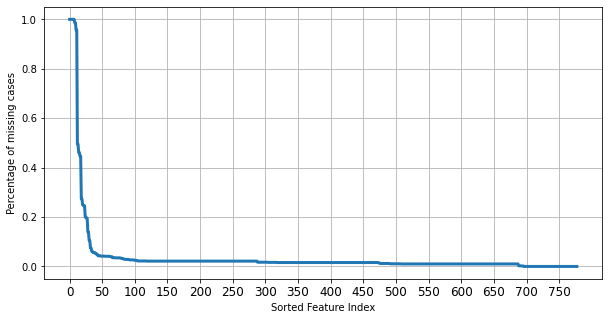

In [27]:
missing_ratio = agg_feature.isnull().sum(axis=0)/len(agg_feature)

agg_feature_percent_missing  = agg_feature.loc[:,(missing_ratio[missing_ratio<.2]).index]
num_eliminated = agg_feature.shape[1]-agg_feature_percent_missing.shape[1]
num_total = agg_feature.shape[1]
print(f"{num_eliminated}/{num_total} features were missing more than 20% of the time")

# visuzlize missing ratio
plt.figure(figsize=(10,5))
N, D = agg_feature.shape
missing_ratio.sort_values(ascending=False).plot(linewidth=3)
I = np.arange(0,D,50)
plt.xticks(I,I, fontsize=12);
plt.grid()
plt.xlabel('Sorted Feature Index')
plt.ylabel('Percentage of missing cases')


##### Pairwise Correlation

###### prepare features order
- features highly correlated with target variable should come first in corr matrix


In [28]:
corr_with_outcome = pd.merge(
    labels_arm[['disturbance']],
    agg_feature_percent_missing
    ,left_index=True, right_index=True
).corr()['disturbance'].abs().sort_values(ascending=False)
corr_with_outcome

disturbance                                  1.000
ringer#SUP:RINGER_MODE_NORMAL|mean           0.256
data_RX2TX#MAX|std                           0.192
battery_plugState#SUP:WIRELESS|std           0.177
battery_plugState#SUP:WIRELESS|mean          0.170
                                              ... 
bandUV_indexLevel#SUP:MEDIUM|std             0.000
bandAmbientLight_brightness#MINLAGVAL|mean   0.000
bandHeartRate_BPM#MINLAG|std                 0.000
location_distance#BEP|mean                   0.000
accelerometer_Z#SKW|std                      0.000
Name: disturbance, Length: 755, dtype: float64

In [29]:
importance_order = corr_with_outcome.index.to_list()[1:] # remove `disturbance`
Matrix = agg_feature_percent_missing[importance_order].corr()

Matrix

,ringer#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#MAX|std,battery_plugState#SUP:WIRELESS|std,battery_plugState#SUP:WIRELESS|mean,data_RX2TX#VAR|std,data_RX2TX#MAX|mean,data_RX2TX#VAR|mean,appUsage_appPackage#ETP|mean,screen#ASC|mean,appUsage_appPackage#ASC|mean,...,data_TX#SKW|std,bandDistance_pace#MIN|mean,accelerometer_Y#MIN|std,location_cluster#ETP|std,bandUV_indexLevel#SUP:MEDIUM|mean,bandUV_indexLevel#SUP:MEDIUM|std,bandAmbientLight_brightness#MINLAGVAL|mean,bandHeartRate_BPM#MINLAG|std,location_distance#BEP|mean,accelerometer_Z#SKW|std
ringer#SUP:RINGER_MODE_NORMAL|mean,1.000,-0.096,0.331,0.372,-0.083,-0.101,-0.079,-0.101,-0.128,-0.149,...,0.013,-0.021,0.020,-0.088,-0.012,-0.012,-0.001,0.009,-0.018,0.077
data_RX2TX#MAX|std,-0.096,1.000,-0.034,-0.028,0.643,0.691,0.511,0.269,0.216,0.226,...,0.032,0.033,0.026,0.080,-0.013,-0.013,-0.049,-0.003,-0.021,0.008
battery_plugState#SUP:WIRELESS|std,0.331,-0.034,1.000,0.749,-0.042,-0.046,-0.040,-0.019,-0.026,-0.034,...,0.056,0.048,0.029,0.031,-0.004,-0.004,-0.018,0.022,0.013,0.088
battery_plugState#SUP:WIRELESS|mean,0.372,-0.028,0.749,1.000,-0.039,-0.048,-0.037,-0.067,-0.058,-0.075,...,0.029,0.054,-0.010,-0.020,-0.004,-0.004,-0.018,0.003,0.038,0.096
data_RX2TX#VAR|std,-0.083,0.643,-0.042,-0.039,1.000,0.668,0.907,0.137,0.161,0.109,...,-0.037,0.048,-0.023,0.063,-0.011,-0.011,-0.054,-0.047,-0.010,-0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bandUV_indexLevel#SUP:MEDIUM|std,-0.012,-0.013,-0.004,-0.004,-0.011,-0.016,-0.011,0.025,0.092,0.035,...,-0.013,-0.006,-0.008,0.062,1.000,1.000,-0.026,0.009,-0.064,-0.015
bandAmbientLight_brightness#MINLAGVAL|mean,-0.001,-0.049,-0.018,-0.018,-0.054,-0.011,-0.045,0.028,0.002,0.018,...,0.007,-0.057,-0.060,-0.029,-0.026,-0.026,1.000,-0.003,-0.002,0.095
bandHeartRate_BPM#MINLAG|std,0.009,-0.003,0.022,0.003,-0.047,-0.002,-0.056,0.088,0.013,0.065,...,0.009,-0.119,0.265,0.003,0.009,0.009,-0.003,1.000,0.010,0.057
location_distance#BEP|mean,-0.018,-0.021,0.013,0.038,-0.010,0.009,0.001,-0.086,-0.200,-0.154,...,-0.015,-0.007,0.023,-0.347,-0.064,-0.064,-0.002,0.010,1.000,0.074


In [30]:
top100_correlated_features = list(
    set(map(lambda x: x[:x.find('|')], importance_order[:100]))
)
top100_correlated_features

['bandDistance_speed#BEP',
 'bandPedometer_step#ASC',
 'bandDistance_speed#AVG',
 'accelerometer_Y#LTS',
 'accelerometer_Y#AVG',
 'bandPedometer_step#AVG',
 'wifi_numConnections#MED',
 'bandPedometer_step#BEP',
 'bandPedometer_step#VAR',
 'data_RX2TX#AVG',
 'data_TX#CID',
 'appUsage_appCategory#ASC',
 'bandDistance_pace#MINLAGVAL',
 'activity_event#SUP:WALKING',
 'bandDistance_pace#AVG',
 'wifi_numConnections#LTI',
 'data_RX2TX#BEP',
 'wifi_numConnections#CID',
 'bandAmbientLight_brightness#MIN',
 'appUsage_appCategory#SUP:Tools',
 'bandDistance_pace#LTI',
 'data_RX2TX#MINLAGVAL',
 'unlock#SUP:UNLOCK',
 'wifi_numConnections#SKW',
 'data_RX#ASC',
 'data_TX#ASC',
 'appUsage_appPackage#ASC',
 'connection_status#SUP:False',
 'data_RX2TX#LTS',
 'ringer#SUP:RINGER_MODE_SILENT',
 'ringer#SUP:RINGER_MODE_NORMAL',
 'appUsage_appCategory#ETP',
 'data_TX#LTI',
 'bandGSR_resistance#MINLAGVAL',
 'wifi_numConnections#AVG',
 'activity_event#ASC',
 'battery_temperature#BEP',
 'wifi_numConnections#MAXL

In [184]:
pd.merge(
    labels_arm[['disturbance']],
    agg_feature_percent_missing
    ,left_index=True, right_index=True
).corr()['disturbance'].abs().sort_values(ascending=False)[:100].to_csv('top_100_correlates.csv')

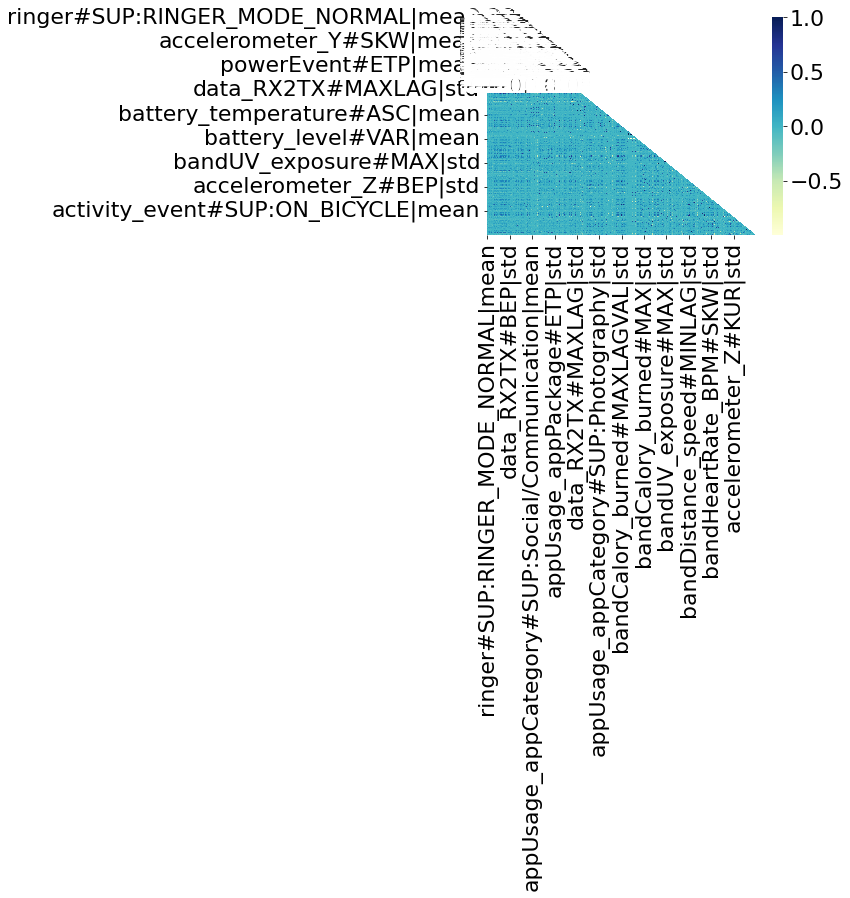

In [ ]:
pd.set_option("display.precision", 2)
matplotlib.rc('font', size=22)

import seaborn as sns
sns.heatmap(
    Matrix, cmap="YlGnBu",fmt='.2f' 
    ,annot=True, mask=np.triu(np.ones_like(Matrix))
)

In [77]:
import pandas
pd.set_option("display.precision", 2)
Matrix.iloc[:10,:10].style.background_gradient(cmap='coolwarm')

,ringer#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#MAX|std,battery_plugState#SUP:WIRELESS|std,battery_plugState#SUP:WIRELESS|mean,data_RX2TX#VAR|std,data_RX2TX#MAX|mean,data_RX2TX#VAR|mean,appUsage_appPackage#ETP|mean,screen#ASC|mean,appUsage_appPackage#ASC|mean
ringer#SUP:RINGER_MODE_NORMAL|mean,1.00,-0.10,0.33,0.37,-0.08,-0.10,-0.08,-0.10,-0.13,-0.15
data_RX2TX#MAX|std,-0.10,1.00,-0.03,-0.03,0.64,0.69,0.51,0.27,0.22,0.23
battery_plugState#SUP:WIRELESS|std,0.33,-0.03,1.00,0.75,-0.04,-0.05,-0.04,-0.02,-0.03,-0.03
battery_plugState#SUP:WIRELESS|mean,0.37,-0.03,0.75,1.00,-0.04,-0.05,-0.04,-0.07,-0.06,-0.08
data_RX2TX#VAR|std,-0.08,0.64,-0.04,-0.04,1.00,0.67,0.91,0.14,0.16,0.11
data_RX2TX#MAX|mean,-0.10,0.69,-0.05,-0.05,0.67,1.00,0.74,0.42,0.15,0.27
data_RX2TX#VAR|mean,-0.08,0.51,-0.04,-0.04,0.91,0.74,1.00,0.16,0.13,0.11
appUsage_appPackage#ETP|mean,-0.10,0.27,-0.02,-0.07,0.14,0.42,0.16,1.00,0.42,0.82
screen#ASC|mean,-0.13,0.22,-0.03,-0.06,0.16,0.15,0.13,0.42,1.00,0.68
appUsage_appPackage#ASC|mean,-0.15,0.23,-0.03,-0.08,0.11,0.27,0.11,0.82,0.68,1.00


###### selection with pairwise correlation
- find features to be eliminate
- store kept features

In [90]:
def remove_pairwise_corr(Matrix, PAIRWISE_CORR_THRESHOLD = 0.8):
    
    eliminated_features = []
    for r in range(Matrix.shape[0]):
        featurename = Matrix.index[r]   
        if str(featurename) in eliminated_features:
            continue
        pairwise_corr = Matrix.iloc[r,:r]
        eliminated_features+= pairwise_corr[
            pairwise_corr>PAIRWISE_CORR_THRESHOLD
        ].index.to_list()

    kept_features_after_pairwise_correlation = list(
        set(Matrix.index.to_list()) - set(eliminated_features)
    )
    return kept_features_after_pairwise_correlation
kept_features_after_pairwise_correlation = remove_pairwise_corr(Matrix)
len(kept_features_after_pairwise_correlation)

394

###### fit classifier after eliminating multi colliniearity

In [32]:
feature_selection={'status':False}
use_ray = False

measure = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(
            agg_feature_percent_missing[kept_features_after_pairwise_correlation]
        )
        ,left_index=True, right_index=True
    )
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

0it [00:00, ?it/s]


NameError: name 'BALANCED_TRAINING' is not defined

##### LogReg+Lasso 

In [188]:

from random import random

data = pd.merge(
        labels_arm[['receptivity']],
        impute(
            agg_feature_percent_missing[kept_features_after_pairwise_correlation]
        )
        ,left_index=True, right_index=True
)

clf = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=RANDOM_STATE)
clf.fit(
    data.drop(['receptivity'], axis=1)
    , data['receptivity']
)


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

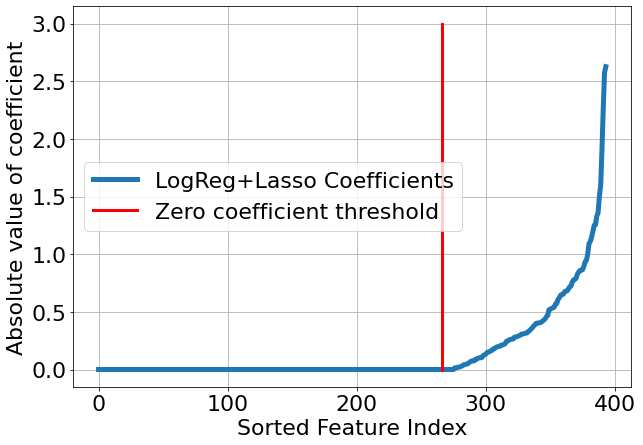

In [192]:
matplotlib.rc('font', size=22)

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(np.abs(clf.coef_[0])), linewidth=5, 
    label = 'LogReg+Lasso Coefficients'
)
plt.xlabel('Sorted Feature Index')
plt.ylabel("Absolute value of coefficient")

plt.plot(
    [len(clf.coef_[0]) - 128,len(clf.coef_[0])-128],[0,3], color='red', linewidth=3
    , label='Zero coefficient threshold'
)
plt.legend()


In [193]:
lasso_features = np.array(
    kept_features_after_pairwise_correlation
)[np.abs(clf.coef_[0])>0]
len(lasso_features)

128

###### test fit

In [194]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(agg_feature_percent_missing[
            #kept_features_after_pairwise_correlation
            lasso_features
        ])
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 21.37it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,62.695,61.088,59.643,0.621,73.564,71.503,71.903,0.807


#### end of feature selection

In [54]:
len(lasso_features)

128

In [196]:
selected_features = list(
    set(map(lambda x: x[:x.find('|')], lasso_features))
)

pd.DataFrame({
    'features':selected_features
}).to_csv('selected_features.csv',index=False)

print('features selected (mapped from agg. features):'
      ,len(selected_features))



features selected (mapped from agg. features): 105


### Mine Association Rules
- uses RuleGenerateSet
- extract sliding features for (12 hours/20min) * 7 for each participant
- recode sliding features
- mine rules

#### extract sliding features


In [17]:
EXTRACTED_SLIDINGFEATURES = True

if not EXTRACTED_SLIDINGFEATURES:
    import recept_dataset
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        sliding_features = recept_dataset.parallellize_extract_sliding(
                labels=labels_arm 
                , _sw_size_in_min = 20
                , selected_features=pd.read_csv(
                    'selected_features.csv'
                )['features'].values
            )
    sliding_features.to_csv('feature/arm/sliding_features.csv')
else:
    sliding_features = pd.read_csv(
        'feature/arm/sliding_features.csv'
        , dtype={'pid':'str'}
        , parse_dates=['timestamp']
    ).set_index(['pid','timestamp'])


sliding_features.isnull().sum().sort_values(ascending=False)     


bandCalory_burned#SKW             2559
ringer#ETP                        2159
ringer#ASC                        2159
bandHeartRate_BPM#ASC              708
bandHeartRate_BPM#MAX              708
                                  ... 
ringer#SUP:RINGER_MODE_VIBRATE       0
connection_type#SUP:WIFI             0
connection_status#SUP:False          0
activity_event#SUP:STILL             0
battery_plugState#SUP:WIRELESS       0
Length: 105, dtype: int64

In [18]:
sliding_features.shape

(9072, 105)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, 'battery_temperature#LTS'),
  Text(0.0, 0, 'bandCalory_burned#SKW'),
  Text(20.0, 0, 'bandAmbientLight_brightness#AVG'),
  Text(40.0, 0, 'accelerometer_X#MINLAG'),
  Text(60.0, 0, 'data_RX2TX#MAX'),
  Text(80.0, 0, 'battery_temperature#MAXLAGVAL'),
  Text(100.0, 0, 'ringer#SUP:RINGER_MODE_VIBRATE'),
  Text(120.0, 0, '')])

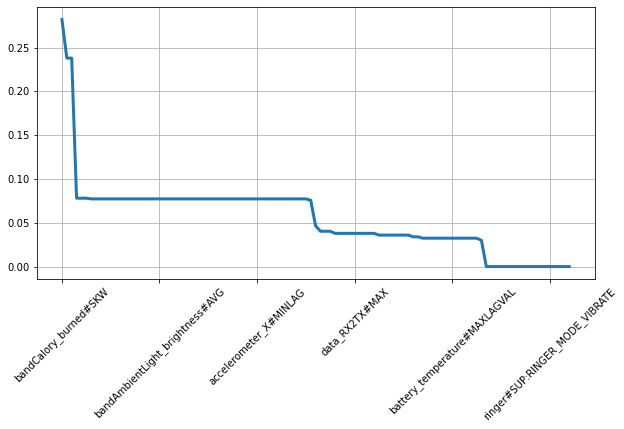

In [19]:
plt.figure(figsize=(10,5))

(sliding_features.isnull().sum(axis=0).sort_values(ascending=False)\
    /len(sliding_features)).plot(linewidth=3)
plt.grid(True)
plt.xticks(rotation=45, fontsize=10)

#### impute

In [20]:
imputed_sliding_features = impute(sliding_features)

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values


#### Recode

In [21]:

    
from copy import deepcopy        
def discretize_df(data, cols, pid):
    df = deepcopy(data)
    count2 = 0
    count1 = 0
    count3 = 0
    for col in cols:
        try:
            df[col] = pd.qcut(df[col], 3, labels=["l","m","h"])
            count3 += 1
        except:
            try:
                df[col] = pd.qcut(df[col], 2, labels=["l","h"])
                count2 += 1
            except:
                df[col] = pd.qcut(df[col], 1, labels=["m"])
                count1 += 1
    #print(col, count1, count2, count3)
    df.insert(0,'pid',pid)
    df = df.reset_index().set_index(['pid']+data.index.names)
    return df


df_recoded = [] 
for pid in tqdm(imputed_sliding_features.index.get_level_values('pid').unique()):    
    #print(f'pid = {pid}')
    res = discretize_df(imputed_sliding_features.loc[pid],
                        imputed_sliding_features.columns.tolist(), pid)
    df_recoded.append(res)
df_recoded = pd.concat(df_recoded)
df_recoded = df_recoded.astype('str').fillna('missing').astype('category')
df_recoded.head()

100%|██████████| 36/36 [00:02<00:00, 12.56it/s]


appUsage_appCategory#ASC  \
pid  timestamp                                      
1501 2019-05-16 10:20:00                        l   
     2019-05-16 10:40:00                        l   
     2019-05-16 11:00:00                        l   
     2019-05-16 11:20:00                        l   
     2019-05-16 11:40:00                        l   

                         appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp                                                           
1501 2019-05-16 10:20:00                                             m   
     2019-05-16 10:40:00                                             l   
     2019-05-16 11:00:00                                             m   
     2019-05-16 11:20:00                                             m   
     2019-05-16 11:40:00                                             l   

                         appUsage_appCategory#SUP:Tools  \
pid  timestamp                                            
1501 2019-05-16 10:20:00                              l   
     2019-05-16 10:40:00                              l   
     2019-05-16 11:00:00                              l   
     2019-05-16 11:20:00                              l   
     2019-05-16 11:40:00                              l   

                         battery_temperature#MAX battery_temperature#BEP  \
pid  timestamp                                                             
1501 2019-05-16 10:20:00                       m                       m   
     2019-05-16 10:40:00                       l                       l   
     2019-05-16 11:00:00                       l                       h   
     2019-05-16 11:20:00                       l                       h   
     2019-05-16 11:40:00                       l                       h   

                         battery_temperature#VAR battery_temperature#MAXLAG  \
pid  timestamp                                                                
1501 2019-05-16 10:20:00                       h                          m   
     2019-05-16 10:40:00                       m                          m   
     2019-05-16 11:00:00                       l                          m   
     2019-05-16 11:20:00                       l                          m   
     2019-05-16 11:40:00                       l                          m   

                         battery_temperature#MAXLAGVAL  \
pid  timestamp                                           
1501 2019-05-16 10:20:00                             m   
     2019-05-16 10:40:00                             m   
     2019-05-16 11:00:00                             m   
     2019-05-16 11:20:00                             h   
     2019-05-16 11:40:00                             m   

                         battery_temperature#MINLAG  \
pid  timestamp                                        
1501 2019-05-16 10:20:00                          m   
     2019-05-16 10:40:00                          m   
     2019-05-16 11:00:00                          m   
     2019-05-16 11:20:00                          m   
     2019-05-16 11:40:00                          m   

                         battery_temperature#MINLAGVAL  ...  \
pid  timestamp                                          ...   
1501 2019-05-16 10:20:00                             h  ...   
     2019-05-16 10:40:00                             m  ...   
     2019-05-16 11:00:00                             m  ...   
     2019-05-16 11:20:00                             m  ...   
     2019-05-16 11:40:00                             m  ...   

                         bandDistance_speed#MAXLAGVAL bandDistance_speed#CID  \
pid  timestamp                                                                 
1501 2019-05-16 10:20:00                            m                      h   
     2019-05-16 10:40:00                            m                      h   
     2019-05-16 11:00:00                            m                      h  

### convert to transaction list

In [22]:
dataset = []
for i, r in df_recoded.iterrows():
    transaction = [f'{featurename}:{value}' 
                   for featurename, value in zip(r.index, r.values)]
    dataset.append(transaction)

    

#### mine Rules

In [23]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import (
    apriori, fpmax,fpgrowth, association_rules
)


te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df


,accelerometer_X#CID:h,accelerometer_X#CID:l,accelerometer_X#CID:m,accelerometer_X#LTI:h,accelerometer_X#LTI:l,accelerometer_X#LTI:m,accelerometer_X#MINLAG:h,accelerometer_X#MINLAG:l,accelerometer_X#MINLAG:m,accelerometer_X#MINLAGVAL:h,...,wifi_numConnections#MAXLAGVAL:m,wifi_numConnections#MED:h,wifi_numConnections#MED:l,wifi_numConnections#MED:m,wifi_numConnections#MIN:h,wifi_numConnections#MIN:l,wifi_numConnections#MIN:m,wifi_numConnections#MINLAG:h,wifi_numConnections#MINLAG:l,wifi_numConnections#MINLAG:m
0,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
4,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,True,False,False,False,True,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
9068,False,False,True,False,True,False,True,False,False,False,...,True,False,True,False,False,True,False,False,True,False
9069,False,False,True,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
9070,False,False,True,True,False,False,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False


In [24]:
frequent_itemsets = fpgrowth(
    df, min_support=0.3, use_colnames=True,
    max_len=5
)

frequent_itemsets

In [119]:
res = association_rules(
    frequent_itemsets
    , metric='confidence'
    ,  min_threshold=0.2
)
res

  0%|          | 0/37 [2:31:18<?, ?it/s]


: 

: 

### consequent length=1 filter

In [118]:
res = res[res.apply(lambda x: len(x['consequents'])==1, axis=1)]
res

KeyError: 'consequents'

### filter rules for only top100 features

In [35]:
res = res[
    res.apply(
        lambda x: list(x['consequents'])[0][:-2] in top100_correlated_features
        , axis=1
    )
]
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
50,(connection_type#SUP:WIFI:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
53,(appUsage_appCategory#SUP:Media/Entertainment:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
54,(battery_status#SUP:FULL:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
56,(bandUV_indexLevel#SUP:NONE:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
60,"(connection_type#SUP:WIFI:m, appUsage_appCateg...",(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
...,...,...,...,...,...,...,...,...,...
51911471,"(activity_event#SUP:STILL:m, battery_status#SU...",(unlock#SUP:UNLOCK:m),0.500,1.000,0.500,1.000,1.000,0.000,inf
51911502,"(activity_event#SUP:STILL:m, battery_status#SU...",(battery_plugState#SUP:WIRELESS:m),0.500,1.000,0.500,1.000,1.000,0.000,inf
51911531,"(activity_event#SUP:STILL:m, battery_status#SU...",(ringer#SUP:RINGER_MODE_NORMAL:m),0.500,1.000,0.500,1.000,1.000,0.000,inf
51911561,"(activity_event#SUP:STILL:m, battery_status#SU...",(activity_event#SUP:WALKING:m),0.500,0.972,0.500,1.000,1.029,0.014,inf


In [36]:
res = res.assign(
    lift_log_scale_abs = np.log(res.lift)
)

topk_rules = pd.concat([
    res.sort_values(['lift_log_scale_abs'],ascending=False)[:1000]
    #, res.sort_values(['lift_log_scale_abs'],ascending=False)[-500:]
])
    
topk_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lift_log_scale_abs
18446517,"(connection_status#SUP:False:m, screen#ETP:l, ...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
18445482,"(connection_status#SUP:False:m, screen#ETP:l, ...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
18446817,"(bandUV_indexLevel#SUP:NONE:m, connection_stat...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
18446787,"(connection_status#SUP:False:m, battery_status...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
18446727,"(connection_status#SUP:False:m, screen#ETP:l, ...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
...,...,...,...,...,...,...,...,...,...,...
47967986,"(location_distance#MINLAG:m, unlock#SUP:UNLOCK...",(bandDistance_speed#BEP:m),0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539
47967955,"(appUsage_appCategory#SUP:Finance:m, unlock#SU...",(bandDistance_speed#BEP:m),0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539
47967926,"(bandUV_indexLevel#SUP:NONE:m, location_distan...",(bandDistance_speed#BEP:m),0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539
47967896,"(location_distance#MINLAG:m, battery_status#SU...",(bandDistance_speed#BEP:m),0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539


#### save rules

In [37]:
topk_rules["antecedents"] = topk_rules["antecedents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode")

topk_rules["consequents"] = topk_rules["consequents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode")

topk_rules.to_csv('top1000_rules.csv', index=False)

In [38]:
topk_rules_df = pd.read_csv('top1000_rules.csv')
topk_rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lift_log_scale_abs
0,"connection_status#SUP:False:m, screen#ETP:l, c...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
1,"connection_status#SUP:False:m, screen#ETP:l, b...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
2,"bandUV_indexLevel#SUP:NONE:m, connection_statu...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
3,"connection_status#SUP:False:m, battery_status#...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
4,"connection_status#SUP:False:m, screen#ETP:l, a...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742,0.755
...,...,...,...,...,...,...,...,...,...,...
995,"location_distance#MINLAG:m, unlock#SUP:UNLOCK:...",bandDistance_speed#BEP:m,0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539
996,"appUsage_appCategory#SUP:Finance:m, unlock#SUP...",bandDistance_speed#BEP:m,0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539
997,"bandUV_indexLevel#SUP:NONE:m, location_distanc...",bandDistance_speed#BEP:m,0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539
998,"location_distance#MINLAG:m, battery_status#SUP...",bandDistance_speed#BEP:m,0.528,0.583,0.528,1.000,1.714,0.220,inf,0.539


# MLTrainEvalSet

In [39]:
selected_features = pd.read_csv('selected_features.csv')['features'].to_list()
len(selected_features),selected_features[:5]

(105,
 ['bandDistance_speed#MAXLAGVAL',
  'bandCalory_burned#MAXLAG',
  'wifi_numConnections#MIN',
  'bandCalory_burned#CID',
  'bandAmbientLight_brightness#VAR'])

### Full features

#### Extract 

In [42]:
ML_FULL_FEATURE_EXTRACTED=True
if not ML_FULL_FEATURE_EXTRACTED:
    ml_full_features = recept_dataset.parallellize_extract(
        labels=labels_ml, 
        w_size_in_min=80,
        selected_features=selected_features
        , use_ray =True
    )
    ml_full_features.to_csv(f'feature/ml/full_{window_size_in_min}MIN.csv')
else:
    ml_full_features = pd.read_csv(f'feature/ml/full_{window_size_in_min}MIN.csv'
        , dtype={'pid':'str'}
        , parse_dates=['timestamp']
    ).set_index(['pid','timestamp'])
ml_full_features

appUsage_appCategory#ASC  \
pid  timestamp                                       
3041 2019-05-01 10:30:08                    98.000   
     2019-05-01 11:26:31                    87.000   
     2019-05-01 13:00:57                    68.000   
     2019-05-01 14:31:22                    27.000   
     2019-05-01 15:11:33                    42.000   
...                                            ...   
1511 2019-05-22 16:40:14                    46.000   
     2019-05-22 18:09:50                    74.000   
     2019-05-22 18:56:25                    79.000   
     2019-05-22 19:47:55                   106.000   
     2019-05-22 21:08:00                    12.000   

                          appUsage_appCategory#SUP:Finance  \
pid  timestamp                                               
3041 2019-05-01 10:30:08                           124.000   
     2019-05-01 11:26:31                           403.000   
     2019-05-01 13:00:57                           333.000   
     2019-05-01 14:31:22                             0.000   
     2019-05-01 15:11:33                             0.000   
...                                                    ...   
1511 2019-05-22 16:40:14                             2.000   
     2019-05-22 18:09:50                            11.000   
     2019-05-22 18:56:25                             7.000   
     2019-05-22 19:47:55                             0.000   
     2019-05-22 21:08:00                             0.000   

                          appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp                                                            
3041 2019-05-01 10:30:08                                       1897.000   
     2019-05-01 11:26:31                                       2622.000   
     2019-05-01 13:00:57                                       1187.000   
     2019-05-01 14:31:22                                       1008.000   
     2019-05-01 15:11:33                                       2654.000   
...                                                                 ...   
1511 2019-05-22 16:40:14                                        929.000   
     2019-05-22 18:09:50                                        458.000   
     2019-05-22 18:56:25                                        744.000   
     2019-05-22 19:47:55                                        705.000   
     2019-05-22 21:08:00                                         70.000   

                          appUsage_appCategory#SUP:Tools  \
pid  timestamp                                             
3041 2019-05-01 10:30:08                        1321.000   
     2019-05-01 11:26:31                         619.000   
     2019-05-01 13:00:57                         390.000   
     2019-05-01 14:31:22                         262.000   
     2019-05-01 15:11:33                         330.000   
...                                                  ...   
1511 2019-05-22 16:40:14                        1599.000   
     2019-05-22 18:09:50                        1219.000   
     2019-05-22 18:56:25                        1350.000   
     2019-05-22 19:47:55                         685.000   
     2019-05-22 21:08:00                         456.000   

                          battery_temperature#MAX  battery_temperature#BEP  \
pid  timestamp                                                               
3041 2019-05-01 10:30:08                   29.100                    1.358   
     2019-05-01 11:26:31                   34.100                    2.157   
     2019-05-01 13:00:57                   34.645                    2.117   
     2019-05-01 14:31:22                   34.800                    2.020   
     2019-05-01 15:11:33                   35.800                    1.928   
...                                           ...                      ...   
1511 2019-05-22 16:40:14                   34.400                    1.776   
     2019-05-22 18:09:50                   34.600        

In [43]:
ml_full_features.isnull().sum().sort_values(ascending=False)

battery_plugState#SUP:WIRELESS                   1491
connection_type#SUP:MOBILE                        857
ringer#SUP:RINGER_MODE_NORMAL                     619
ringer#SUP:RINGER_MODE_SILENT                     420
battery_status#SUP:FULL                           226
                                                 ... 
unlock#SUP:UNLOCK                                   0
screen#SUP:SCREEN_OFF                               0
appUsage_appCategory#SUP:Tools                      0
appUsage_appCategory#SUP:Social/Communication       0
activity_event#SUP:WALKING                          0
Length: 105, dtype: int64

#### Classification

In [114]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False
measure_list = []
for i, clfname in enumerate(classifier_names):
    measure = run_classification(
        pd.merge(
            labels_ml[['receptivity']],
            impute(
                impute_support_features(
                    normalize(
                        ml_full_features
                    )
                )
            )
            ,left_index=True, right_index=True
        ) 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)
pd.concat(measure_list).groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values
5it [00:00, 19.79it/s]
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [115]:
pd.concat(measure_list).groupby(['CV_TYPE','experiment']).mean()

TEST_ACC  TEST_ACC_BAL  TEST_F1_score  \
CV_TYPE    experiment                                                           
LOGO_5fold adaboost                       55.617        53.833         53.162   
           catboost                       59.326        55.429         52.785   
           dt                             55.227        53.301         52.822   
           gnb                            55.644        55.504         54.491   
           gp                             58.511        54.033         50.701   
           knn                            54.669        53.004         51.921   
           lr                             59.281        56.125         55.480   
           lr_lasso_C=0.01                58.471        50.000         36.739   
           lr_lasso_C=0.1                 59.197        53.267         47.743   
           lr_lasso_C=0.1_maxiter=1000    59.197        53.267         47.743   
           mlp                            57.619        54.158         53.310   
           qda                            57.113        55.008         54.359   
           rf                             58.268        53.364         50.469   
           svm                            59.147        55.952         54.431   

                                        TEST_AUC  TRAIN_ACC  TRAIN_ACC_BAL  \
CV_TYPE    experiment                                                        
LOGO_5fold adaboost                        0.568     76.723         75.113   
           catboost                        0.568     99.273         99.131   
           dt                              0.533    100.000        100.000   
           gnb                             0.586     64.168         64.837   
           gp                              0.538     90.936         89.237   
           knn                             0.541     76.652         75.315   
           lr                              0.569     71.438         68.800   
           lr_lasso_C=0.01                 0.500     58.440         50.000   
           lr_lasso_C=0.1                  0.519     63.242         57.035   
           lr_lasso_C=0.1_maxiter=1000     0.519     63.242         57.035   
           mlp                             0.562     85.692         84.177   
           qda                             0.572     88.626         88.823   
           rf                              0.552    100.000        100.000   
           svm                             0.575     74.302         71.227   

                                        TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                              
LOGO_5fold adaboost                             75.496      0.852  
           catboost                             99.249      1.000  
           dt                                  100.000      1.000  
           gnb                                  63.928      0.700  
           gp                                   90.276      0.982  
           knn                                  75.597      0.834  
           lr                                   69.146      0.767  
           lr_lasso_C=0.01                      36.875      0.500  
           lr_lasso_C=0.1                       53.179      0.674  
           lr_lasso_C=0.1_maxiter=1000          53.179      0.674  
           mlp                                  84.699      0.926  
           qda                                  88.387      0.939  
           rf                                  100.000      1.000  
           svm                                  71.626      0.809

In [116]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False
measure_list = []
keept_features = remove_pairwise_corr(ml_full_features.corr())
for i, clfname in enumerate(classifier_names):
    measure = run_classification(
        pd.merge(
            labels_ml[['receptivity']],
            impute(
                impute_support_features(
                    normalize(
                        ml_full_features[keept_features]
                    )
                )
            )
            ,left_index=True, right_index=True
        ) 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)
pd.concat(measure_list).groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values
5it [00:00, 20.73it/s]
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 

TEST_ACC  TEST_ACC_BAL  TEST_F1_score  \
CV_TYPE    experiment                                                           
LOGO_5fold adaboost                       55.356        53.162         52.398   
           catboost                       60.251        56.142         53.786   
           dt                             52.843        51.516         50.867   
           gnb                            56.095        55.725         54.876   
           gp                             58.732        54.208         51.019   
           knn                            54.634        52.960         51.959   
           lr                             59.633        56.432         55.877   
           lr_lasso_C=0.01                58.471        50.000         36.739   
           lr_lasso_C=0.1                 59.197        53.267         47.743   
           lr_lasso_C=0.1_maxiter=1000    59.197        53.267         47.743   
           mlp                            58.853        55.249         54.564   
           qda                            57.236        55.565         54.939   
           rf                             58.353        54.300         51.406   
           svm                            59.673        56.309         54.929   

                                        TEST_AUC  TRAIN_ACC  TRAIN_ACC_BAL  \
CV_TYPE    experiment                                                        
LOGO_5fold adaboost                        0.563     76.057         74.426   
           catboost                        0.574     99.258         99.105   
           dt                              0.515    100.000        100.000   
           gnb                             0.588     64.781         65.185   
           gp                              0.540     90.693         88.968   
           knn                             0.539     76.338         74.921   
           lr                              0.573     70.853         68.157   
           lr_lasso_C=0.01                 0.500     58.440         50.000   
           lr_lasso_C=0.1                  0.519     63.242         57.035   
           lr_lasso_C=0.1_maxiter=1000     0.519     63.242         57.035   
           mlp                             0.570     85.436         83.906   
           qda                             0.570     87.415         87.746   
           rf                              0.553    100.000        100.000   
           svm                             0.577     74.416         71.376   

                                        TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                              
LOGO_5fold adaboost                             74.800      0.851  
           catboost                             99.232      1.000  
           dt                                  100.000      1.000  
           gnb                                  64.458      0.702  
           gp                                   90.013      0.981  
           knn                                  75.231      0.833  
           lr                                   68.481      0.764  
           lr_lasso_C=0.01                      36.875      0.500  
           lr_lasso_C=0.1                       53.179      0.674  
           lr_lasso_C=0.1_maxiter=1000          53.179      0.674  
           mlp                                  84.481      0.928  
           qda                                  87.186      0.934  
           rf                                  100.000      1.000  
           svm                                  71.811      0.812


### Agg 

#### extract sub features
- extract sub features only for selected 


In [46]:
from itertools import product
nsub = 4
window_size_in_min = 80
ML_AGG_FEATURE_EXTRACTED = True

if not ML_AGG_FEATURE_EXTRACTED:
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=20):    
        print(f'{window_size_in_min}MIN at {nsub} subwindows')
        ml_sub_features = recept_dataset.parallellize_extract_sub(
            labels=labels_ml
            , w_size_in_min = 80
            ,num_sub=4
            , selected_features=selected_features
        )
        ml_sub_features.to_csv(
            f'feature/ml/subfeature_{window_size_in_min}MIN_{nsub}.csv'
        )
else:
    ml_sub_features = pd.read_csv(
        f'feature/ml/subfeature_{window_size_in_min}MIN_{nsub}.csv'
        , dtype={'pid':'str'}
        , parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
ml_sub_features

appUsage_appCategory#ASC  \
pid  timestamp           sub_timestamp                                   
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                    23.000   
                         2019-05-01 09:50:08                    23.000   
                         2019-05-01 10:10:08                    19.000   
                         2019-05-01 10:30:08                    33.000   
     2019-05-01 11:26:31 2019-05-01 10:26:31                    33.000   
...                                                                ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                    37.000   
     2019-05-22 21:08:00 2019-05-22 20:08:00                     9.000   
                         2019-05-22 20:28:00                     0.000   
                         2019-05-22 20:48:00                     0.000   
                         2019-05-22 21:08:00                     3.000   

                                              appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp           sub_timestamp                                                        
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                                        309.000   
                         2019-05-01 09:50:08                                        473.000   
                         2019-05-01 10:10:08                                        643.000   
                         2019-05-01 10:30:08                                        472.000   
     2019-05-01 11:26:31 2019-05-01 10:26:31                                        543.000   
...                                                                                     ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                                        362.000   
     2019-05-22 21:08:00 2019-05-22 20:08:00                                         70.000   
                         2019-05-22 20:28:00                                          0.000   
                         2019-05-22 20:48:00                                          0.000   
                         2019-05-22 21:08:00                                          0.000   

                                              appUsage_appCategory#SUP:Tools  \
pid  timestamp           sub_timestamp                                         
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                          64.000   
                         2019-05-01 09:50:08                         354.000   
                         2019-05-01 10:10:08                         508.000   
                         2019-05-01 10:30:08                         396.000   
     2019-05-01 11:26:31 2019-05-01 10:26:31                         398.000   
...                                                                      ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                         217.000   
     2019-05-22 21:08:00 2019-05-22 20:08:00                         438.000   
                         2019-05-22 20:28:00                           0.000   
                         2019-05-22 20:48:00                           0.000   
                         2019-05-22 21:08:00                          18.000   

                                              battery_temperature#MAX  \
pid  timestamp           sub_timestamp                                  
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                   26.205   
                         2019-05-01 09:50:08                   26.157   
                         2019-05-01 10:10:08                   27.900   
                         2019-05-01 10:30:08                   29.100   
     2019-05-01 11:26:31 2019-05-01 10:26:31                   28.742   
...                                                               ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                   31.270   
     2019-05-22 21:08:00 2019-05-22 20:08:00                   32.200   
                         2019-05-22 20:28:00                   29.638   
   

In [47]:
ml_sub_features.isnull().sum()

appUsage_appCategory#ASC                         73
appUsage_appCategory#SUP:Social/Communication     0
appUsage_appCategory#SUP:Tools                    0
battery_temperature#MAX                          72
battery_temperature#BEP                          72
                                                 ..
ringer#SUP:RINGER_MODE_SILENT                     0
ringer#SUP:RINGER_MODE_NORMAL                     0
connection_type#SUP:MOBILE                        0
appUsage_appCategory#SUP:Media/Entertainment      0
battery_plugState#SUP:WIRELESS                    0
Length: 105, dtype: int64

#### extract aggregated features
- sub feature prep 
    - impute support features before agg feature compute
- agg features should be extracted from sub features
    - normalize
    - impute

In [48]:
ml_agg_feature = ml_sub_features.groupby(
    ['pid','timestamp']
).agg(['mean','std'])
ml_agg_feature.columns = ml_agg_feature.columns.map('|'.join).str.strip('|')
ml_agg_feature.to_csv(
    f'feature/ml/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
)

In [49]:
ml_agg_feature

appUsage_appCategory#ASC|mean  \
pid  timestamp                                            
1502 2019-05-16 11:19:31                         40.750   
     2019-05-16 12:49:26                         18.750   
     2019-05-16 13:31:07                         21.250   
     2019-05-16 14:25:57                         12.500   
     2019-05-16 15:10:31                         14.250   
...                                                 ...   
726  2019-05-13 20:22:29                          2.000   
     2019-05-14 10:21:48                          0.500   
     2019-05-14 13:40:06                          6.000   
     2019-05-14 14:29:57                         11.500   
     2019-05-14 18:11:42                          6.750   

                          appUsage_appCategory#ASC|std  \
pid  timestamp                                           
1502 2019-05-16 11:19:31                        13.301   
     2019-05-16 12:49:26                        18.173   
     2019-05-16 13:31:07                        17.576   
     2019-05-16 14:25:57                        14.844   
     2019-05-16 15:10:31                        15.840   
...                                                ...   
726  2019-05-13 20:22:29                         3.367   
     2019-05-14 10:21:48                         1.000   
     2019-05-14 13:40:06                         6.976   
     2019-05-14 14:29:57                        10.878   
     2019-05-14 18:11:42                         5.909   

                          appUsage_appCategory#SUP:Social/Communication|mean  \
pid  timestamp                                                                 
1502 2019-05-16 11:19:31                                            452.000    
     2019-05-16 12:49:26                                            197.250    
     2019-05-16 13:31:07                                            278.750    
     2019-05-16 14:25:57                                            151.750    
     2019-05-16 15:10:31                                            186.250    
...                                                                     ...    
726  2019-05-13 20:22:29                                              0.250    
     2019-05-14 10:21:48                                              0.500    
     2019-05-14 13:40:06                                             74.500    
     2019-05-14 14:29:57                                            159.750    
     2019-05-14 18:11:42                                            276.250    

                          appUsage_appCategory#SUP:Social/Communication|std  \
pid  timestamp                                                                
1502 2019-05-16 11:19:31                                            271.935   
     2019-05-16 12:49:26                                            237.772   
     2019-05-16 13:31:07                                            296.908   
     2019-05-16 14:25:57                                            209.438   
     2019-05-16 15:10:31                                            269.167   
...                                                                     ...   
726  2019-05-13 20:22:29                                              0.500   
     2019-05-14 10:21:48                                              1.000   
     2019-05-14 13:40:06                                            108.510   
     2019-05-14 14:29:57                                            149.814   
     2019-05-14 18:11:42                                            371.606   

                          appUsage_appCategory#SUP:Tools|mean  \
pid  timestamp                                                  
1502 2019-05-16 11:19:31                              122.250   
     2019-05-16 12:49:26                              348.500   
     2019-05-16 13:31:07                              484.000   
     2019-05-16 14:25:57                              454.000   
     2019-05-16 15:10:31                    

#### Classification performance

In [50]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
            normalize(ml_agg_feature)
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='ml-lr'
    , classifier_name='lr'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 16.60it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,ml-lr,59.415,56.333,55.640,0.591,74.416,72.213,72.671,0.807


### CFF
- sub features
    - impute
    - recode
- compute cff

#### recode sub featyures

In [51]:
ml_sub_features_preprocessed = impute(ml_sub_features)
ml_sub_recoded = [] 
for pid in tqdm(
    ml_sub_features_preprocessed.index.get_level_values('pid').unique()
):    
    res = discretize_df(ml_sub_features_preprocessed.loc[pid],
                        ml_sub_features_preprocessed.columns.tolist(), pid)
    ml_sub_recoded.append(res)
ml_sub_recoded = pd.concat(ml_sub_recoded)
ml_sub_recoded = ml_sub_recoded.astype('str').fillna(
    'missing'
).astype('category')
ml_sub_recoded.head()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values
100%|██████████| 37/37 [00:02<00:00, 12.37it/s]


appUsage_appCategory#ASC  \
pid  timestamp           sub_timestamp                                  
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                        h   
                         2019-05-16 10:39:31                        h   
                         2019-05-16 10:59:31                        h   
                         2019-05-16 11:19:31                        h   
     2019-05-16 12:49:26 2019-05-16 11:49:26                        m   

                                             appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp           sub_timestamp                                                       
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                                             h   
                         2019-05-16 10:39:31                                             h   
                         2019-05-16 10:59:31                                             h   
                         2019-05-16 11:19:31                                             h   
     2019-05-16 12:49:26 2019-05-16 11:49:26                                             m   

                                             appUsage_appCategory#SUP:Tools  \
pid  timestamp           sub_timestamp                                        
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                              h   
                         2019-05-16 10:39:31                              h   
                         2019-05-16 10:59:31                              m   
                         2019-05-16 11:19:31                              m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                              h   

                                             battery_temperature#MAX  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       m   
                         2019-05-16 10:39:31                       m   
                         2019-05-16 10:59:31                       m   
                         2019-05-16 11:19:31                       l   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#BEP  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       h   
                         2019-05-16 10:39:31                       h   
                         2019-05-16 10:59:31                       m   
                         2019-05-16 11:19:31                       m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#VAR  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       m   
                         2019-05-16 10:39:31                       m   
                         2019-05-16 10:59:31                       l   
                         2019-05-16 11:19:31                       l   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#MAXLAG  \
pid  timestamp           sub_timestamp                                    
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                          m   
                         2019-05-16 10:39:31                          m   
                         2019-05-16 10:59:31                          m   
                         2019-05-16 11:19:31                          m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                          m   

                                             battery_temperature#MAXLAGVAL  \
pid  timestamp           sub_timestamp                                       
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                             h   
                         2019-05-16 10:39:31 

#### extract 

- for each rule
  - select the df that satisfy the context
     - extract Y from contextually filtered subfeatures and add to features


In [53]:
rules = pd.read_csv(
    'top1000_rules.csv', usecols=['antecedents','consequents']
    , dtype={'lift':float}
)

rules

,antecedents,consequents
0,"connection_status#SUP:False:m, screen#ETP:l, c...",screen#ASC:l
1,"connection_status#SUP:False:m, screen#ETP:l, b...",screen#ASC:l
2,"bandUV_indexLevel#SUP:NONE:m, connection_statu...",screen#ASC:l
3,"connection_status#SUP:False:m, battery_status#...",screen#ASC:l
4,"connection_status#SUP:False:m, screen#ETP:l, a...",screen#ASC:l
...,...,...
995,"location_distance#MINLAG:m, unlock#SUP:UNLOCK:...",bandDistance_speed#BEP:m
996,"appUsage_appCategory#SUP:Finance:m, unlock#SUP...",bandDistance_speed#BEP:m
997,"bandUV_indexLevel#SUP:NONE:m, location_distanc...",bandDistance_speed#BEP:m
998,"location_distance#MINLAG:m, battery_status#SUP...",bandDistance_speed#BEP:m


In [52]:

features = {}
for i,rule in tqdm(rules.iterrows()):
    X, Y = rule['antecedents'], rule['consequents']
    y_name, y_val = Y[:-2], Y[-1]
    
    for x in X.split(', '):
        
        x_name, x_val = x[:-2], x[-1]
        
        M = ml_sub_recoded[x_name]==x_val
        selected_context = ml_sub_features[M][y_name]
        f = selected_context.groupby(['pid','timestamp']).agg(
                ['mean','std']
        )
        features[f'mean-{y_name}_context={x_name}'] = f['mean']
        features[f'std-{y_name}_context={x_name}'] = f['std']
featuresCFF = pd.DataFrame(features )
featuresCFF.isnull().sum().sort_values(ascending=False)

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
1000it [00:57, 17.40it/s]


std-screen#ASC_context=screen#ETP                                     1058
std-screen#ETP_context=screen#ASC                                      974
std-bandDistance_speed#BEP_context=bandDistance_speed#MAX              639
mean-bandDistance_speed#BEP_context=bandDistance_speed#MAX             628
std-bandDistance_speed#BEP_context=bandDistance_speed#CID              616
                                                                      ... 
mean-bandDistance_speed#BEP_context=battery_plugState#SUP:WIRELESS       3
mean-bandDistance_speed#BEP_context=connection_status#SUP:False          3
mean-bandDistance_speed#BEP_context=unlock#SUP:UNLOCK                    3
mean-bandDistance_speed#BEP_context=bandUV_indexLevel#SUP:NONE           3
mean-bandDistance_speed#BEP_context=connection_type#SUP:MOBILE           3
Length: 108, dtype: int64

#### Classifier Performance

In [54]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False

measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
                normalize(
                    featuresCFF
                )
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values
5it [00:00, 27.74it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,55.387,53.086,52.251,0.556,66.906,64.978,64.677,0.713


In [69]:
featuresCFF.isnull().sum().sort_values(ascending=False)

std-screen#ASC_context=screen#ETP                                     1058
std-screen#ETP_context=screen#ASC                                      974
std-bandDistance_speed#BEP_context=bandDistance_speed#MAX              639
mean-bandDistance_speed#BEP_context=bandDistance_speed#MAX             628
std-bandDistance_speed#BEP_context=bandDistance_speed#CID              616
                                                                      ... 
mean-bandDistance_speed#BEP_context=battery_plugState#SUP:WIRELESS       3
mean-bandDistance_speed#BEP_context=connection_status#SUP:False          3
mean-bandDistance_speed#BEP_context=unlock#SUP:UNLOCK                    3
mean-bandDistance_speed#BEP_context=bandUV_indexLevel#SUP:NONE           3
mean-bandDistance_speed#BEP_context=connection_type#SUP:MOBILE           3
Length: 108, dtype: int64

### Combining

In [95]:
data = pd.merge(
    impute(
        impute_support_features(
            normalize(ml_full_features)
        )
    )
    , 
    impute(
        normalize(featuresCFF)        
    )
    , left_index=True
    , right_index=True 
)
# data = pd.merge(data,ml_agg_feature, left_index=True, right_index=True )
#data = pd.merge(labels_ml[['receptivity']], data, left_index=True, right_index=True )
data.shape

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values


(1754, 213)

In [74]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False

measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        data
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

5it [00:00,  9.53it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,58.147,54.648,54.530,0.560,75.014,73.162,73.549,0.810


In [80]:
data.corr()
# import pandas
# pd.set_option("display.precision", 2)
data.corr().iloc[:10,:10].style.background_gradient(cmap='coolwarm')

,appUsage_appCategory#ASC,appUsage_appCategory#SUP:Finance,appUsage_appCategory#SUP:Social/Communication,appUsage_appCategory#SUP:Tools,battery_temperature#MAX,battery_temperature#BEP,battery_temperature#VAR,battery_temperature#MAXLAG,battery_temperature#MAXLAGVAL,battery_temperature#MINLAG
appUsage_appCategory#ASC,1.00,0.11,0.33,0.22,0.24,0.33,0.15,0.01,0.29,0.11
appUsage_appCategory#SUP:Finance,0.11,1.00,0.11,0.01,0.10,0.05,0.07,0.03,0.05,0.02
appUsage_appCategory#SUP:Social/Communication,0.33,0.11,1.00,0.03,0.19,0.21,0.09,0.02,0.18,0.10
appUsage_appCategory#SUP:Tools,0.22,0.01,0.03,1.00,0.28,0.19,0.11,0.01,0.18,0.11
battery_temperature#MAX,0.24,0.10,0.19,0.28,1.00,0.24,0.44,0.01,0.25,0.21
battery_temperature#BEP,0.33,0.05,0.21,0.19,0.24,1.00,0.13,0.10,0.88,0.59
battery_temperature#VAR,0.15,0.07,0.09,0.11,0.44,0.13,1.00,0.11,0.17,0.27
battery_temperature#MAXLAG,0.01,0.03,0.02,0.01,0.01,0.10,0.11,1.00,0.08,0.14
battery_temperature#MAXLAGVAL,0.29,0.05,0.18,0.18,0.25,0.88,0.17,0.08,1.00,0.69
battery_temperature#MINLAG,0.11,0.02,0.10,0.11,0.21,0.59,0.27,0.14,0.69,1.00


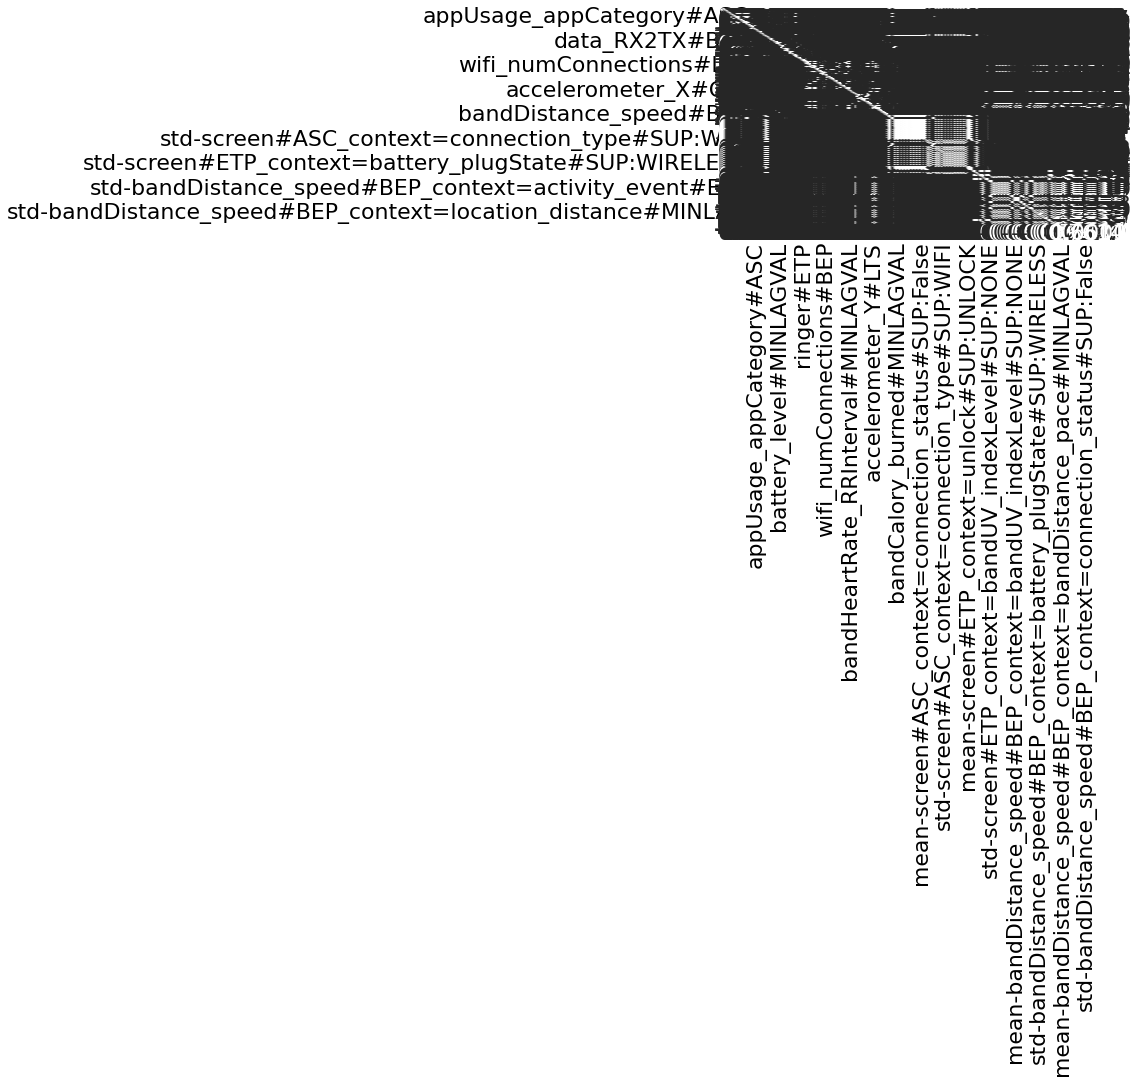

In [82]:
import seaborn as sns
fig, ax = plt.subplots()

sns.heatmap(data.corr(), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

In [98]:
print(data.corr().shape)

keept_features = remove_pairwise_corr(data.corr(), .6)
print(len(keept_features))

(213, 213)
82


In [101]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False
keept_features = remove_pairwise_corr(data.corr(), .65)

measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        data[keept_features]
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray
    , feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 23.14it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,60.217,56.438,56.270,0.582,72.860,70.670,71.052,0.784


In [111]:
measure_list = []
for i,clfname in enumerate(classifier_names):
    print(f'{i}/{len(classifier_names)}:{clfname}')
    measure = run_classification(
        pd.merge(
            labels_ml[['receptivity']],
            data[keept_features]
            ,left_index=True, right_index=True
        ) 
        ,use_ray=use_ray
        , feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)

measure.groupby(['CV_TYPE','experiment']).mean()

0/14:lr


5it [00:00, 17.23it/s]


1/14:lr_lasso_C=0.1


5it [00:00, 22.28it/s]
5it [00:00, 45.65it/s]


2/14:lr_lasso_C=0.01
3/14:lr_lasso_C=0.1_maxiter=1000


5it [00:00, 21.44it/s]


4/14:knn


5it [00:00, 23.79it/s]


5/14:svm


5it [00:01,  3.18it/s]


6/14:gp


5it [00:07,  1.54s/it]


7/14:dt


5it [00:00, 18.52it/s]


8/14:rf


5it [00:01,  2.78it/s]


9/14:mlp


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet

10/14:adaboost


5it [00:01,  3.27it/s]
5it [00:00, 120.75it/s]
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
5it [00:00, 46.60it/s]


11/14:gnb
12/14:qda
13/14:catboost


5it [00:06,  1.22s/it]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,catboost,61.160,56.574,55.464,0.589,99.244,99.116,99.218,1.000


In [112]:
pd.concat(measure_list).groupby(['CV_TYPE','experiment']).mean()

TEST_ACC  TEST_ACC_BAL  TEST_F1_score  \
CV_TYPE    experiment                                                           
LOGO_5fold adaboost                       61.492        58.549         58.346   
           catboost                       61.160        56.574         55.464   
           dt                             53.503        51.268         50.959   
           gnb                            60.519        57.957         57.814   
           gp                             59.829        55.773         54.807   
           knn                            56.227        54.758         54.333   
           lr                             60.217        56.438         56.270   
           lr_lasso_C=0.01                58.471        50.000         36.739   
           lr_lasso_C=0.1                 57.984        52.592         49.764   
           lr_lasso_C=0.1_maxiter=1000    57.984        52.592         49.764   
           mlp                            60.559        56.529         56.150   
           qda                            61.220        57.112         56.702   
           rf                             61.237        56.344         54.614   
           svm                            59.337        55.247         54.279   

                                        TEST_AUC  TRAIN_ACC  TRAIN_ACC_BAL  \
CV_TYPE    experiment                                                        
LOGO_5fold adaboost                        0.606     77.750         76.232   
           catboost                        0.589     99.244         99.116   
           dt                              0.513    100.000        100.000   
           gnb                             0.593     67.049         67.251   
           gp                              0.580     92.402         91.290   
           knn                             0.564     77.564         76.437   
           lr                              0.582     72.860         70.670   
           lr_lasso_C=0.01                 0.500     58.440         50.000   
           lr_lasso_C=0.1                  0.534     66.006         61.373   
           lr_lasso_C=0.1_maxiter=1000     0.534     66.006         61.373   
           mlp                             0.589     87.153         86.260   
           qda                             0.595     86.101         86.077   
           rf                              0.587    100.000        100.000   
           svm                             0.590     76.423         74.085   

                                        TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                              
LOGO_5fold adaboost                             76.612      0.863  
           catboost                             99.218      1.000  
           dt                                  100.000      1.000  
           gnb                                  66.643      0.721  
           gp                                   91.989      0.979  
           knn                                  76.648      0.858  
           lr                                   71.052      0.784  
           lr_lasso_C=0.01                      36.875      0.500  
           lr_lasso_C=0.1                       60.136      0.707  
           lr_lasso_C=0.1_maxiter=1000          60.136      0.707  
           mlp                                  86.527      0.946  
           qda                                  85.775      0.919  
           rf                                  100.000      1.000  
           svm                                  74.553      0.831